In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.model_selection import train_test_split
import gdown
from sklearn.metrics import  confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical


url = "https://drive.google.com/drive/folders/1K28d1ufLIZL6WtQIS4CE4H_EZZAzvTqX?usp=drive_link"
gdown.download_folder(url, quiet=True)

['/content/Progetto/train.csv']

In [10]:
# data preprocessing with OneHot encoding
X = pd.read_csv("/content/Progetto/train.csv")
def handle_dataset(X):
  y = X['Crime_Category']
  X = X.drop('Crime_Category', axis=1)

  # remove column with 80% null values
  X.drop('Cross_Street', axis=1)

  # handle missing data
  X['Victim_Sex'] = X['Victim_Sex'].replace(['H', 'X'], 'Unknown')
  X['Victim_Descent'] = X['Victim_Descent'].fillna('Unknown')
  X['Weapon_Description'] = X['Weapon_Description'].fillna('No Weapon')
  X['Weapon_Used_Code'] = X['Weapon_Used_Code'].fillna(0) # Weapon_Used_Code is in the range [1,3990], 0 is for missing code
  X['Modus_Operandi'] = X['Modus_Operandi'].fillna('Unknown')

  # data handling
  X['Date_Reported'] = pd.to_datetime(X['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
  X['Date_Occurred'] = pd.to_datetime(X['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
  X['Year_Reported'] = X.Date_Reported.dt.year
  X['Year_Occurred'] = X.Date_Occurred.dt.year
  X['Month_Reported'] = X.Date_Reported.dt.month
  X['Month_Occurred'] = X.Date_Occurred.dt.month
  X['Day_Reported'] = X.Date_Reported.dt.day
  X['Day_Occurred'] = X.Date_Occurred.dt.day
  X.drop(['Date_Reported', 'Date_Occurred'], axis=1, inplace=True)

  numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
  categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
  categorical_columns = [col for col in categorical_columns if col != 'Modus_Operandi']

  numerical_pipeline = make_pipeline(
      SimpleImputer(strategy='median'),
      StandardScaler()
  )

  categorical_pipeline = make_pipeline(
      SimpleImputer(strategy='most_frequent'),
      OneHotEncoder(handle_unknown='ignore', sparse_output=False)
      )

  modus_operandi_pipeline = make_pipeline(
      SimpleImputer(strategy='most_frequent'),
      CountVectorizer(preprocessor=lambda x:x[0])
  )

  preprocessor = ColumnTransformer(transformers=[
      ('num', numerical_pipeline, numerical_columns),
      ('cat', categorical_pipeline, categorical_columns),
      ('modus_operandi', modus_operandi_pipeline, ['Modus_Operandi'])
    ])

  #Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # full pipeline
  pipe = make_pipeline(preprocessor)
  #Transform data
  X_train = pipe.fit_transform(X_train)
  X_test = pipe.transform(X_test)
  label_encoder = LabelEncoder()
  y_train= label_encoder.fit_transform(y_train)
  y_test=label_encoder.transform(y_test)
  return X_train, X_test, y_train, y_test


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.7783 - loss: 0.2917 - val_accuracy: 0.9320 - val_loss: 0.0878
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9297 - loss: 0.0915 - val_accuracy: 0.9413 - val_loss: 0.0745
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9406 - loss: 0.0771 - val_accuracy: 0.9440 - val_loss: 0.0688
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9487 - loss: 0.0719 - val_accuracy: 0.9440 - val_loss: 0.0685
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.9478 - loss: 0.0704 - val_accuracy: 0.9485 - val_loss: 0.0640
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.9519 - loss: 0.0651 - val_accuracy: 0.9473 - val_loss: 0.0647
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9526 - loss: 0.0635 - val_accuracy: 0.9498 - val_loss: 0.0638
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.9575 - loss: 0.0616 - 

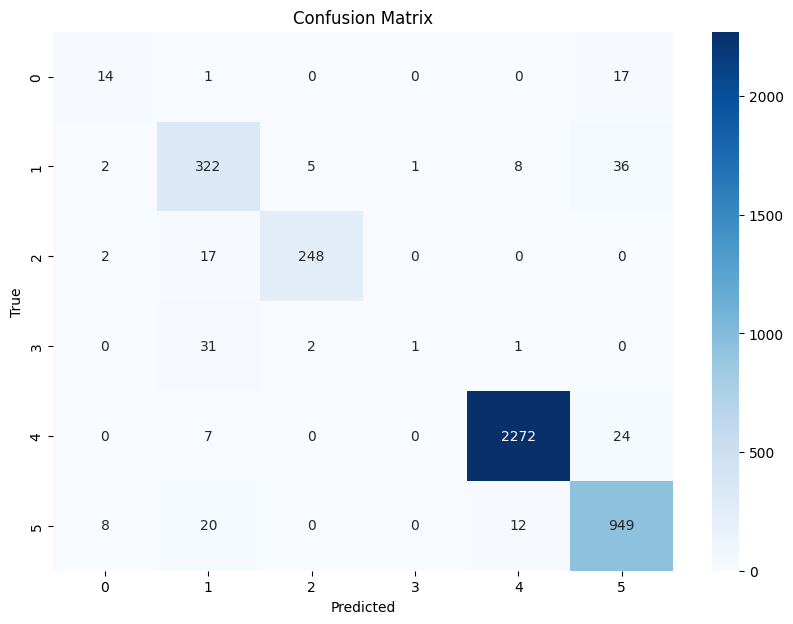

              precision    recall  f1-score   support

           0       0.54      0.44      0.48        32
           1       0.81      0.86      0.83       374
           2       0.97      0.93      0.95       267
           3       0.50      0.03      0.05        35
           4       0.99      0.99      0.99      2303
           5       0.92      0.96      0.94       989

    accuracy                           0.95      4000
   macro avg       0.79      0.70      0.71      4000
weighted avg       0.95      0.95      0.95      4000



In [11]:
X_train, X_test, y_train, y_test=handle_dataset(X)
y_train=to_categorical(y_train)
y_test_to_onehot=to_categorical(y_test)
model = Sequential()
model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))  # Dropout
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))  # Adjust activation based on target variable

# Compile the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Stop training after 3 epochs of no improvement in validation loss
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test_to_onehot), callbacks=[early_stopping])
test_loss, test_acc = model.evaluate(X_test, y_test_to_onehot)
#print('Test accuracy:', test_acc)
y_pred = model.predict(X_test)
y_pred_classes=np.argmax(y_pred,axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
#model.score(X_test,y_test)
report=classification_report(y_test,y_pred_classes)
print(report)
